In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hlpr_func import lat_mean, symmetric_antisymmetric, sindeg,\
    rolling_mean, time_mean, calc_trend_HAC

nicename = {
    "F_TOA": "$F^\\uparrow_{TOA}$",
    "F_surf": "$F_{surf}$",
    "F_clr": "$F_{clr}$",
    "F_cloud": "$F_{cloud}$",
    "aod": "AOD",
    "ssaod550": "sea salt AOD",
    "si10": "wind speed",
}
plotcolor = {
    "F_TOA": "black",
    "F_surf": "mediumseagreen",
    "F_clr": "hotpink",
    "F_cloud": "deepskyblue",
    "aod": "brown",
    "ssaod550": "darkblue",
    "si10": "black",
}
units = {
    "F_TOA":"W m$^{-2}$",
    "F_clr":"W m$^{-2}$",
    "aod":"",
    "ssaod550":"",
    "si10":"m s$^{-1}$",
}

In [2]:
zm = xr.open_mfdataset("CERES-data/CERES_Cru23_zm.nc")
zm = zm.assign_coords({"month_since_start": ("time", np.arange(len(zm.time.values)))})
symmetric, antisymmetric = symmetric_antisymmetric(zm)

# for calculating trends
weights = zm.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
zm["days_in_month"] = weights
symmetric["days_in_month"] = weights
antisymmetric["days_in_month"] = weights

zm_clim = zm.groupby("time.month").mean("time")
zm_anom = zm.groupby("time.month") - zm_clim
symmetric_anom, antisymmetric_anom = symmetric_antisymmetric(zm_anom)
zm_anom["days_in_month"] = weights
symmetric_anom["days_in_month"] = weights
antisymmetric_anom["days_in_month"] = weights

# for plotting
zm_roll = rolling_mean(zm, 12)
symmetric_roll, antisymmetric_roll = symmetric_antisymmetric(zm_roll)
zm_roll["days_in_month"] = weights
symmetric_roll["days_in_month"] = weights
antisymmetric_roll["days_in_month"] = weights

zm_roll

/glade/u/home/csinger/anaconda3/envs/albedo/lib/python3.12/site-packages/xarray/core/indexing.py:1688: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


<xarray.Dataset> Size: 4MB
Dimensions:            (lat: 180, time: 289)
Coordinates:
  * lat                (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time               (time) datetime64[ns] 2kB 2000-03-15 ... 2024-03-15
    month_since_start  (time) int64 2kB 0 1 2 3 4 5 ... 283 284 285 286 287 288
Data variables:
    F_surf             (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_atm              (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    G_atm              (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    G_surf             (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_clr              (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_cloud            (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_TOA              (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_TOA_clr_t        (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    F_TOA_clr_c        (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    S                  (time, lat) float64 416kB dask.array<chunksize=(288, 180), meta=np.ndarray>
    days_in_month      (time) float64 2kB 31.0 30.0 31.0 ... 31.0 28.65 31.0

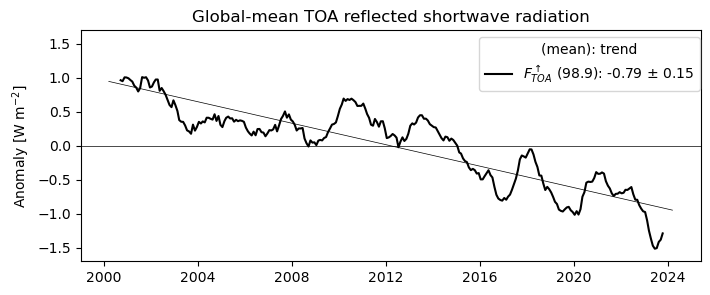

In [5]:
gm_anom = lat_mean(zm_anom)
gm_roll = lat_mean(zm_roll)

fig,axes = plt.subplots(1,1,figsize=(8,3),sharex=True)
ax = axes

for i,var in enumerate(["F_TOA"]):
    f = gm_anom
    fmean = gm_roll.weighted(zm_roll.days_in_month).mean("time")
    f_roll = gm_roll - fmean

    y = f[var].dropna(dim="time")
    t = y.month_since_start.values
    w = f.days_in_month.dropna(dim="time").values
    fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
    label = "{} ({:.1f}): {:.2f} $\\pm$ {:.2f}".format(nicename[var], fmean[var].values, trend*120, trend_pm*120) # 120 to make per decade, not per month
    
    ax.plot(f_roll.time, f_roll[var], color=plotcolor[var], label=label)
    ax.plot(f[var].dropna("time").time, fitted, color=plotcolor[var], lw=0.5)
    ax.axhline(0, color="k", lw=0.5)
    ax.legend(title="(mean): trend", bbox_to_anchor=(1.01,1.0))
    ax.set_title(r"Global-mean TOA reflected shortwave radiation")
    ax.set_ylim(-1.7,1.7)
    ax.set_ylabel("Anomaly [W m$^{-2}$]")

plt.savefig("talk-figures/gm_Cru23_trends_total.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

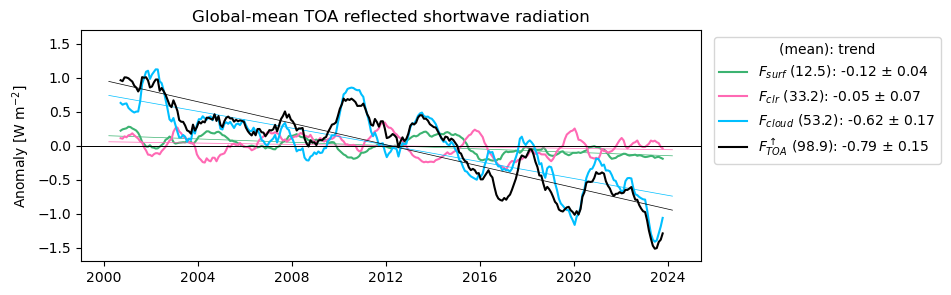

In [6]:
fig,axes = plt.subplots(1,1,figsize=(8,3),sharex=True)
ax = axes

for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
    f = gm_anom
    fmean = gm_roll.weighted(zm_roll.days_in_month).mean("time")
    f_roll = gm_roll - fmean
    y = f[var].dropna(dim="time")
    t = y.month_since_start.values
    w = f.days_in_month.dropna(dim="time").values
    fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
    label = "{} ({:.1f}): {:.2f} $\\pm$ {:.2f}".format(nicename[var], fmean[var].values, trend*120, trend_pm*120) # 120 to make per decade, not per month

    ax.plot(f_roll.time, f_roll[var], color=plotcolor[var], label=label)
    ax.plot(f[var].dropna("time").time, fitted, color=plotcolor[var], lw=0.5)
    ax.axhline(0, color="k", lw=0.5)
    ax.legend(title="(mean): trend", bbox_to_anchor=(1.01,1.0))
    ax.set_title(r"Global-mean TOA reflected shortwave radiation")
    ax.set_ylim(-1.7,1.7)
    ax.set_ylabel("Anomaly [W m$^{-2}$]")

plt.savefig("talk-figures/gm_Cru23_trends.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

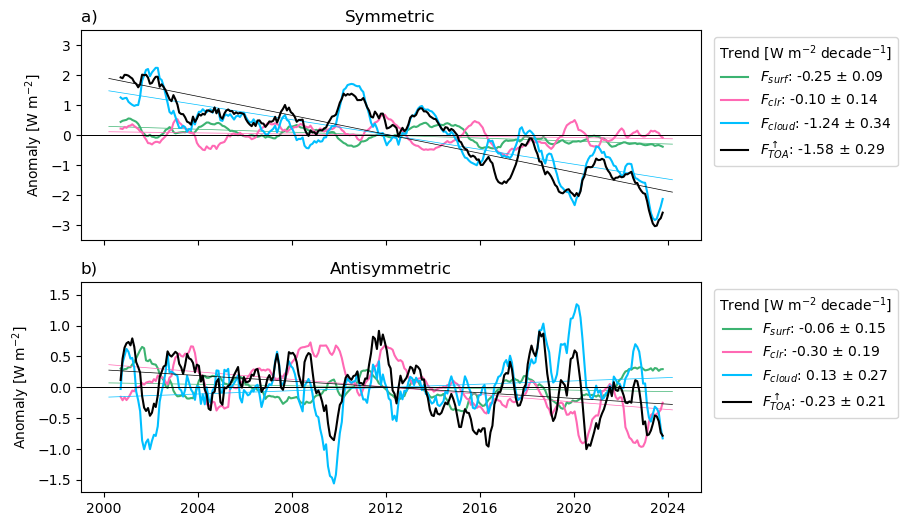

In [7]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)

for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
    for j,ax in enumerate(axes.flatten()):
        if j == 1:
            f = lat_mean(antisymmetric_anom.sel(lat=slice(0,90))) * 2
            froll_abs = lat_mean(antisymmetric_roll.sel(lat=slice(0,90))) * 2
            froll_mean = froll_abs.weighted(froll_abs.days_in_month).mean("time")
            f_roll = froll_abs - froll_mean
            ax.set_title("Antisymmetric")
            ax.set_ylabel("Anomaly [W m$^{-2}$]")
            ax.set_ylim([-1.7,1.7])
            ax.set_title("b)", loc="left")
        elif j == 0:
            f = lat_mean(symmetric_anom.sel(lat=slice(0,90))) * 2
            froll_abs = lat_mean(symmetric_roll.sel(lat=slice(0,90))) * 2
            froll_mean = froll_abs.weighted(froll_abs.days_in_month).mean("time")
            f_roll = froll_abs - froll_mean
            ax.set_title("Symmetric")
            ax.set_ylabel("Anomaly [W m$^{-2}$]")
            ax.set_ylim([-3.5,3.5])
            ax.set_title("a)", loc="left")

        y = f[var].dropna(dim="time")
        t = y.month_since_start.values
        w = f.days_in_month.dropna(dim="time").values
        fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
        label = "{}: {:.2f} $\\pm$ {:.2f}".format(nicename[var], trend*120, trend_pm*120) # 120 to make per decade, not per month

        ax.plot(f_roll.time, f_roll[var], color=plotcolor[var], label=label)
        ax.plot(f[var].dropna("time").time, fitted, color=plotcolor[var], lw=0.5)
        ax.axhline(0, color="k", lw=0.5)
        ax.legend(title="Trend [W m$^{-2}$ decade$^{-1}$]", bbox_to_anchor=(1.01,1.0))

plt.savefig("paper-figures/sym-asym-ts.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

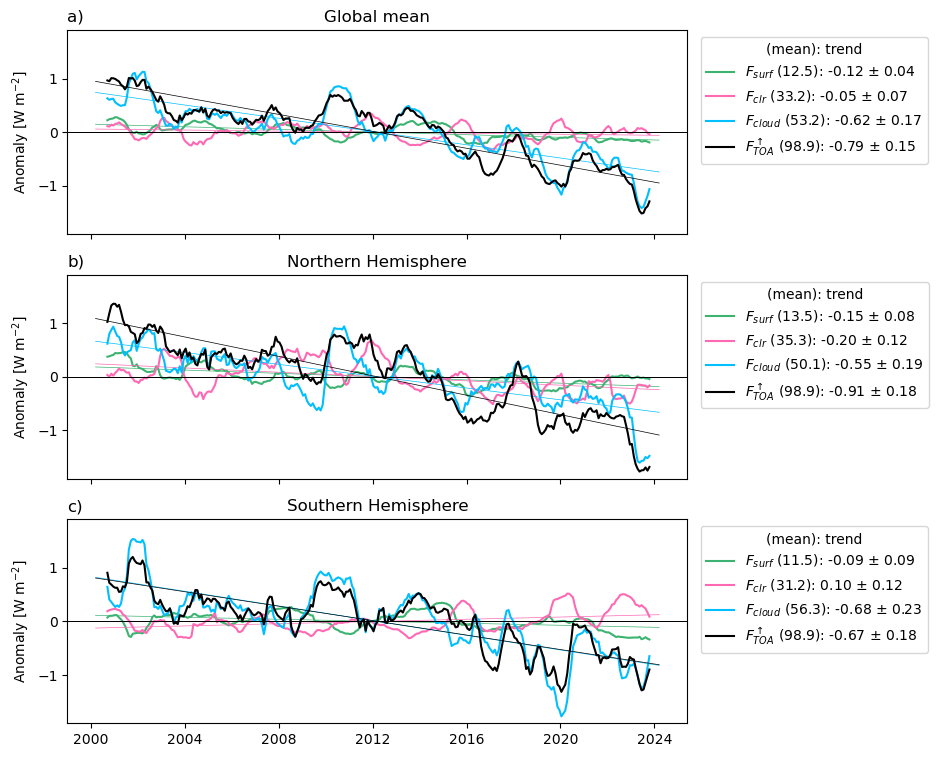

In [8]:
fig,axes = plt.subplots(3,1,figsize=(8,9),sharex=True)

for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
    for j in np.arange(3):
        ax = axes[j]
        if j == 0:
            f = lat_mean(zm_anom)
            fmean = lat_mean(zm_roll).weighted(zm_roll.days_in_month).mean("time")
            f_roll = lat_mean(zm_roll) - fmean
        if j == 1:
            f = lat_mean(zm_anom.sel(lat=slice(0,90)))
            fmean = lat_mean(zm_roll.sel(lat=slice(0,90))).weighted(zm_roll.days_in_month).mean("time")
            f_roll = lat_mean(zm_roll.sel(lat=slice(0,90))) - fmean
        if j == 2:
            f = lat_mean(zm_anom.sel(lat=slice(-90,0)))
            fmean = lat_mean(zm_roll.sel(lat=slice(-90,0))).weighted(zm_roll.days_in_month).mean("time")
            f_roll = lat_mean(zm_roll.sel(lat=slice(-90,0))) - fmean

        y = f[var].dropna(dim="time")
        t = y.month_since_start.values
        w = f.days_in_month.dropna(dim="time").values
        fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
        label = "{} ({:.1f}): {:.2f} $\\pm$ {:.2f}".format(nicename[var], fmean[var].values, trend*120, trend_pm*120) # 120 to make per decade, not per month
    
        ax.plot(f_roll.time, f_roll[var], color=plotcolor[var], label=label)
        ax.plot(f[var].dropna("time").time, fitted, color=plotcolor[var], lw=0.5)
        ax.axhline(0, color="k", lw=0.5)
        ax.legend(title="(mean): trend", bbox_to_anchor=(1.01,1.0))
        ax.set_title(["Global mean", "Northern Hemisphere", "Southern Hemisphere"][j])
        ax.set_ylim(-1.9,1.9)
        ax.set_ylabel("Anomaly [W m$^{-2}$]")
        ax.set_title(["a)", "b)", "c)"][j], loc="left")

plt.savefig("paper-figures/nh_sh_trends.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

In [14]:
Nslices = 50

meanlat = np.zeros(Nslices)
slope = np.zeros((Nslices, 4, 4))
slope_err = np.zeros((Nslices, 4, 4))

for k in range(Nslices):
    lat_slice = slice(np.rad2deg(np.arcsin(k * (1/Nslices))), np.rad2deg(np.arcsin((k+1) * (1/Nslices))))
    meanlat[k] = (k+0.5) * (1/Nslices)
    fa = lat_mean(antisymmetric_anom.sel(lat=lat_slice))*2
    fs = lat_mean(symmetric_anom.sel(lat=lat_slice))*2
    nh = lat_mean(zm_anom.sel(lat=lat_slice))
    neg_slice = slice(-1*np.rad2deg(np.arcsin((k+1) * (1/Nslices))), -1*np.rad2deg(np.arcsin(k * (1/Nslices))))
    sh = lat_mean(zm_anom.sel(lat=neg_slice))
    # for each component...
    for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
        # symmetric
        y = fs[var].dropna(dim="time")
        t = y.month_since_start.values
        w = fs.days_in_month.dropna(dim="time").values
        _, slope[k,i,0], slope_err[k,i,0] = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
        # antisymmetric
        y = fa[var].dropna(dim="time")
        t = y.month_since_start.values
        w = fa.days_in_month.dropna(dim="time").values
        _, slope[k,i,1], slope_err[k,i,1] = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
        # NH
        y = nh[var].dropna(dim="time")
        t = y.month_since_start.values
        w = nh.days_in_month.dropna(dim="time").values
        _, slope[k,i,2], slope_err[k,i,2] = calc_trend_HAC(t, y.values, w, hac_maxlags=12)
        # SH
        y = sh[var].dropna(dim="time")
        t = y.month_since_start.values
        w = sh.days_in_month.dropna(dim="time").values
        _, slope[k,i,3], slope_err[k,i,3] = calc_trend_HAC(t, y.values, w, hac_maxlags=12)

dt = xr.Dataset(
    data_vars = {
        "trend": (["lat","rad","comp"], slope),
        "trend_err": (["lat","rad","comp"], slope_err),
    },
    coords = {
        "lat": ("lat", meanlat),
        "rad": ("rad", ["F_surf","F_clr","F_cloud","F_TOA"]),
        "comp": ("comp", ["Symmetric","Antisymmetric","NH","SH"]),
    })

dt["signif"] = xr.where(np.abs(dt.trend) > dt.trend_err, 1, np.nan)
dt["signif_trend"] = dt.trend * dt.signif

In [17]:
dt.to_netcdf("CERES-data/trends_Cru23_N50.nc")

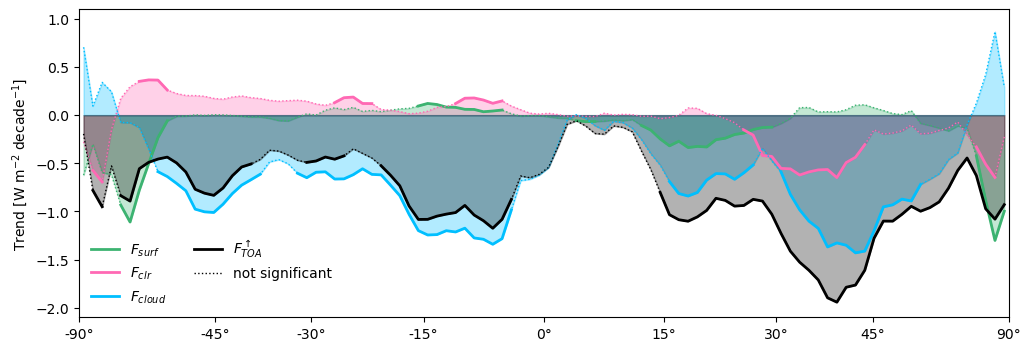

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
    nh = dt.sel(comp="NH").sel(rad=var)
    sh = dt.sel(comp="SH").sel(rad=var)
    sh["lat"] = sh.lat * -1
    da = xr.concat([sh,nh], dim="lat")
    da = da.sortby("lat")
    
    ax.plot(da.lat, da.signif_trend * 120, lw=2, color=plotcolor[var], label=nicename[var])
    ax.plot(da.lat, da.trend * 120, lw=1, ls=":", color=plotcolor[var], label="not significant" if var == "F_TOA" else "")
    ax.fill_between(da.lat, 0, da.trend * 120, color=plotcolor[var], alpha=0.1 if plotcolor[var] == "k" else 0.3)
    ax.set_ylabel("Trend [W m$^{-2}$ decade$^{-1}$]")
    ax.set_ylim(-2.1,1.1)
    ax.legend(frameon=False, loc=3, ncols=2)
    xticks = [-90, -45, -30, -15, 0, 15, 30, 45, 90]
    ax.set_xticks(sindeg(xticks),[str(xt)+"°" for xt in xticks])
    ax.set_xlim(-1,1)

plt.savefig("talk-figures/zm_trends_signif_Cru23.png".format(Nslices), dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

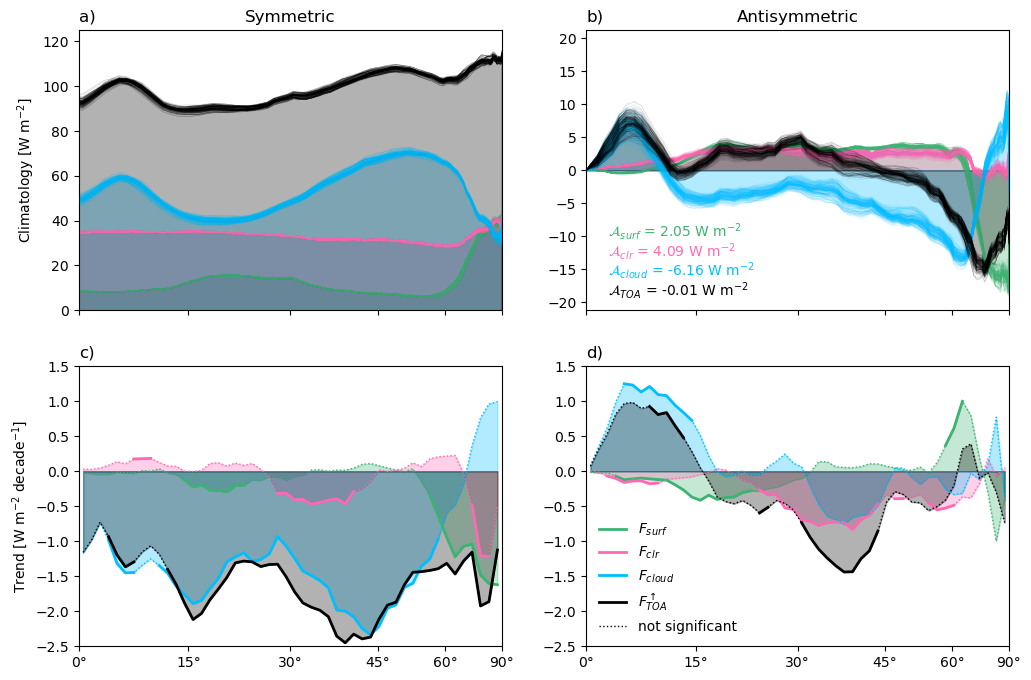

In [16]:
fig,axes = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey=False)
for i,var in enumerate(["F_surf","F_clr","F_cloud","F_TOA"]):
    ax = axes[0,0]
    ax.plot(sindeg(symmetric_roll.lat), symmetric_roll[var].T, lw=0.2, alpha=0.2, color=plotcolor[var])
    ax.fill_between(sindeg(symmetric_roll.lat), 0, time_mean(symmetric_roll)[var], color=plotcolor[var], alpha=0.1 if plotcolor[var] == "k" else 0.3)
    ax.set_title("Symmetric")
    ax.set_xticks([0,np.sin(np.deg2rad(15)),.5,np.sin(np.deg2rad(45)), np.sin(np.deg2rad(60)),1],["0°","15°","30°","45°","60°","90°"])
    ax.set_xlim(0,1)
    ax.set_ylim(0,125)
    ax.set_ylabel("Climatology [W m$^{-2}$]")
    ax.set_title("a)", loc="left")

    ax = axes[0,1]
    ax.plot(sindeg(antisymmetric_roll.lat), antisymmetric_roll[var].T, lw=0.2, alpha=0.2, color=plotcolor[var])
    ax.fill_between(sindeg(antisymmetric_roll.lat), 0, time_mean(antisymmetric_roll)[var], color=plotcolor[var], alpha=0.1 if plotcolor[var] == "k" else 0.3)
    ax.set_title("Antisymmetric")
    asym = lat_mean(time_mean(antisymmetric_roll)[var].sel(lat=slice(0,90))).values * 2
    ax.text(np.deg2rad(3), -10-3*i, r"$\mathcal{{A}}_{{{}}}$ = {:.2f} W m$^{{-2}}$".format(var.split("F_")[1], asym), color=plotcolor[var])
    ax.set_title("b)", loc="left")

    ax = axes[1,0]
    da = dt.sel(comp="Symmetric").sel(rad=var)
    ax.plot(dt.lat, da.signif_trend * 120, lw=2, color=plotcolor[var])
    ax.plot(dt.lat, da.trend * 120, lw=1, ls=":", color=plotcolor[var])
    ax.fill_between(dt.lat, 0, da.trend * 120, color=plotcolor[var], alpha=0.1 if plotcolor[var] == "k" else 0.3)
    ax.set_ylim(-2.5,1.5)
    ax.set_ylabel("Trend [W m$^{-2}$ decade$^{-1}$]")
    ax.set_title("c)", loc="left")

    ax = axes[1,1]
    da = dt.sel(comp="Antisymmetric").sel(rad=var)
    ax.plot(dt.lat, da.signif_trend * 120, lw=2, color=plotcolor[var], label=nicename[var])
    ax.plot(dt.lat, da.trend * 120, lw=1, ls=":", color=plotcolor[var], label="not significant" if var == "F_TOA" else "")
    ax.fill_between(dt.lat, 0, da.trend * 120, color=plotcolor[var], alpha=0.1 if plotcolor[var] == "k" else 0.3)
    ax.legend(frameon=False)
    ax.set_ylim(-2.5,1.5)
    ax.set_title("d)", loc="left")


plt.savefig("paper-figures/zm-clim-trends-sym-asym.png".format(Nslices), dpi=200, facecolor="w", bbox_inches="tight")
plt.show()